In [45]:
import math
import numpy as np
from matplotlib import pyplot as plt

In [42]:
def Joukowski(z, c):
    return z + c/z



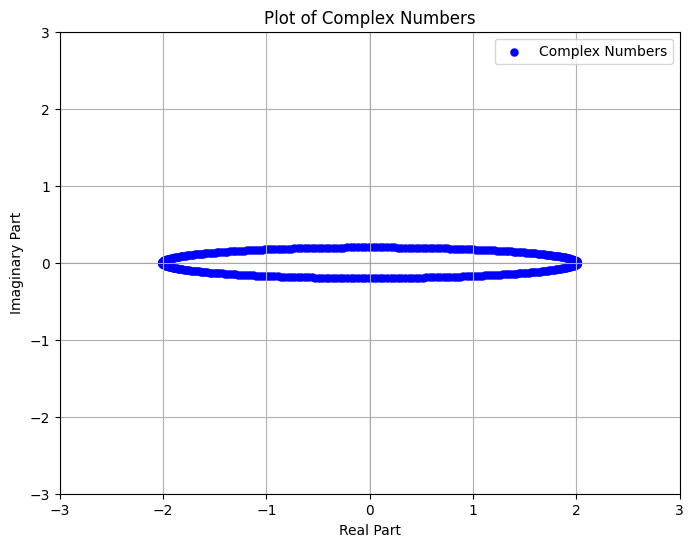

In [56]:
theta = np.linspace(0,360,360)
c = 1
dx = -0.1
dy = 0.1 
r = math.sqrt((c-dx)**2 + dy**2)
x = np.array([r*math.cos(th*np.pi/180)+dx for th in theta])
y = np.array([r*1j*math.sin(th*np.pi/180)+dy for th in theta])
z = x + y

jou = Joukowski(z,c)

jx = jou.real
jy = jou.imag

plt.figure(figsize=(8, 6))
plt.scatter(jx, jy, color='blue',linewidth=0.1, label='Complex Numbers')
plt.axhline(0, color='black', linewidth=0.1, ls='--')
plt.axvline(0, color='black', linewidth=0.1, ls='--')
plt.title('Plot of Complex Numbers')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.grid()
plt.legend()
plt.show()

## Pannel method


In [57]:
from scipy import integrate
%matplotlib inline

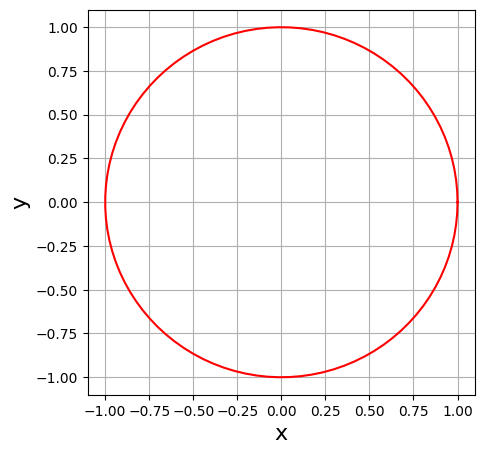

In [62]:
# freee stream 
uinf = 1

# Defining a sphere 
r = 1
xc, yc = 0,0
theta = np.linspace(0,2*np.pi,100)
x_cylinder = xc + r*np.cos(theta) 
y_cylinder = yc + r*np.sin(theta) 

#Ploting the cylinder 
width = 5
plt.figure(figsize = (width,width))
plt.grid() 
plt.xlabel('x', fontsize = 16)
plt.ylabel('y',fontsize=16)
plt.plot(x_cylinder, y_cylinder, color='red')


In [67]:
#pannel class

class Pannel:
    def __init__(self, xa,ya,xb,yb):

        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb

        self.xc, self.yc = (xa+xb)/2 , (ya+yb)/2
        self.length = math.sqrt((xa-xb)**2 + (ya-yb)**2)  ## length of the pannel

        if xb-xa <=0:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa >0:
            self.beta = math.pi + math.acos((ya-yb)/self.length)

        self.sigma = 0
        self.vt = 0
        self.cp = 0


def intigrate_normal(p_i, p_j):
    """
    Evaluates the contribution of a panel at the center-point of another,
    in the normal direction.
    
    Parameters
    ----------
    p_i: Panel object
        Panel on which the contribution is calculated.
    p_j: Panel object
        Panel from which the contribution is calculated.
    
    Returns
    -------
    Integral over the panel at the center point of the other.
    """
    def integrands(s):
        return (((p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))*math.cos(p_i.beta) +
                 (p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))*math.sin(p_i.beta))/
                 ((p_i.xc - (p_j.xa - math.sin(p_j.beta)*s))**2 + 
                  (p_i.yc - (p_j.ya - math.cos(p_j.beta)*s))**2))
    
    return integrate.quad(integrands, 0.0, p_j.length)[0]

## to find pressure coefficient- we need the tangential velocity 

def integrate_tangential(p_i,p_j):

    """  p_i: Panel object
        Panel on which the contribution is calculated.
    p_j: Panel object
        Panel from which the contribution is calculated.
        """
    
    def integrand(s):
              return ((-(p_i.xc - (p_j.xa - math.sin(p_j.beta) * s)) * math.sin(p_i.beta) +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s)) * math.cos(p_i.beta)) /
                ((p_i.xc - (p_j.xa - math.sin(p_j.beta) * s))**2 +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s))**2))
    return integrate.quad(integrand, 0.0, p_j.length)[0]

In [ ]:
N_pannel = 10

theta_pannel = np.linspace(0,2*np.pi, N_pannel+1)
x_pend = xc + r*np.cos(theta)
y_pend = yc + r*np.sin(theta)

pannels = np.empty(N_pannel, dtype=object)

for i in range(0,N_pannel):
    pannels[i] = Pannel(x_pend[i],y_pend[i], x_pend[i+1], y_pend[i+1])


## source and influence matrix 
A = np.empty([N_pannel, N_pannel],dtype= object)
np.fill_diagonal(A,0.5)  ## for i =j  the voriticity strength os sigma/2 will ensure that there is no penetration to surface

for i, p_i in enumerate(pannels):
    for j, p_j in enumerate(pannels):
        if i!=j:
            A[i,j] = 0.5/math.pi*intigrate_normal(p_i,p_j)

## matrix b
b = -uinf*np.cos([p.beta for p in pannels])

## solve the linear equation 
sigma = np.linalg.solve(A,b)

for i,pannel in enumerate(pannels):
    pannel.sigma = sigma[i]

A = np.empty([N_pannel , N_pannel], dtype = object)
np.fill_diagonal(A , 0)

for i, pi in enumerate(pannels):
    for j, pj in enumerate(pannels):
        if i!=j:
            A[i,j] = 0.5/math.pi*integrate_tangential(pi,pj)

# fixed velocity component 
b = -uinf*np.sin([pannel.beta for pannel in pannels])

vt = np.dot(A,sigma) + b

for i, pannel in enumerate(pannel):
    pannel.vt = vt[i]

## calculating Cp 

for i , pannel in enumerate(pannels):
    pannel.cp = 1 - (pannel.vt/ uinf)**2

UFuncTypeError: Cannot cast ufunc 'solve1' input 0 from dtype('O') to dtype('float64') with casting rule 'same_kind'

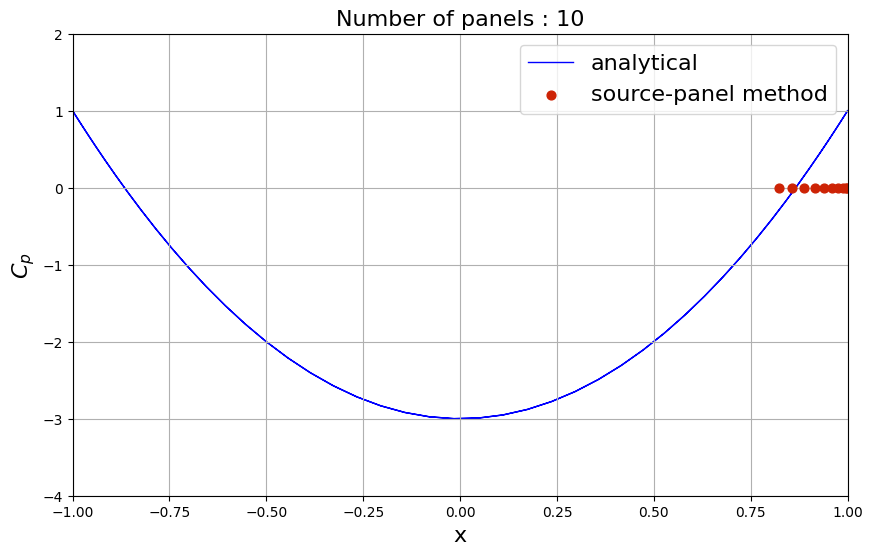

In [71]:
# calculate the analytical surface pressure coefficient
cp_analytical = 1.0 - 4 * (y_cylinder / r)**2

# plot the surface pressure coefficient
plt.figure(figsize=(10, 6))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot(x_cylinder, cp_analytical,
            label='analytical',
            color='b', linestyle='-', linewidth=1, zorder=1)
plt.scatter([p.xc for p in pannels], [p.cp for p in pannels],
               label='source-panel method',
               color='#CD2305', s=40, zorder=2)
plt.title('Number of panels : %d' % N_pannel, fontsize=16)
plt.legend(loc='best', prop={'size':16})
plt.xlim(-1.0, 1.0)
plt.ylim(-4.0, 2.0);